In [5]:
%reset -f

### Project goal: to develop a scoring model for predicting customer default

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split # tool for splitting dataset:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, \
            accuracy_score, precision_score, recall_score, f1_score, \
            confusion_matrix, auc, roc_auc_score, roc_curve

In [7]:
RANDOM_SEED = 42 # fix RANDOM_SEED

# DATA

In [9]:
df_train = pd.read_csv( 'train.csv') # train 
df_test  = pd.read_csv( 'test.csv')  # test

print('train\t', df_train.shape)
print('test:\t', df_test.shape)

pd.set_option('display.max_rows', 100)  # show more rows
pd.set_option('display.max_columns', None)

train	 (73799, 19)
test:	 (36349, 18)


In [10]:
df_train.loc[:,'part'] = 1 # mark a train part
df_test.loc[:,'part'] = 0 # mark a test part

# merge train & test into one dataset
df = df_train.append(df_test, sort=False).reset_index(drop=True) # merge
df.shape

(110148, 20)

# 1. Preprocessing

In [11]:
print('columns with nan values:\t', *df.columns[df.isnull().sum()>0],sep=' | ')
print('2 unique values:', *df.columns[df.nunique()==2], sep=' | ')
print('> 2 unique values:\n', *df.columns[df.nunique()>2], sep=' | ')

columns with nan values:	 | education | default
2 unique values: | sex | car | car_type | good_work | foreign_passport | default | part
> 2 unique values:
 | client_id | app_date | education | age | decline_app_cnt | score_bki | bki_request_cnt | region_rating | home_address | work_address | income | sna | first_time


In [12]:
# app_date

# convert to date format
df.loc[:,'app_date'] = pd.to_datetime(df.app_date, format='%d%b%Y')

# create a new features
df.loc[:,'day_num'] = (df['app_date'] - df['app_date'].min()).dt.days

# drop 'app_date'
df.drop('app_date', axis=1, inplace=True)

null values:  478


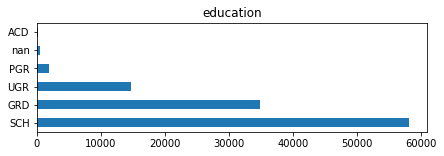

In [13]:
    # education

print("null values: ", df.education.isna().sum() )

# visualization
plt.figure(figsize=(7,2)) # size of figure
df.education.value_counts(dropna=False).plot.barh()
plt.title('education')
plt.show()

In [14]:
# education': fill nan values with the most frequent value 'SCH'
df.loc[:,'education'].fillna('SCH', inplace=True)
print('null: ',df.education.isnull().sum().sum()) # check null values

# 'education' encoding 
df.loc[:, 'education_code'] = df.education.replace({'SCH':1, 'ACD':2,'UGR':2, 'GRD':3, 'PGR':4})

null:  0


In [15]:
# split columns into several groups

target = 'default'
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # binary variables
cat_cols = ['education_code', 'work_address', 'sna','first_time','region_rating'] # categorical variables
num_cols = ['age', 'decline_app_cnt','score_bki','bki_request_cnt','income','day_num'] # numeric variables

In [16]:
# LabelEncoder for bin columns

label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    
df.sample(3) # check

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,part,day_num,education_code
53278,77451,SCH,1,26,1,0,2,1,-1.037306,0,60,2,3,30000,1,2,0,1.0,1,83,1
43135,87500,SCH,0,27,1,0,0,0,-2.415844,0,60,2,3,29000,1,4,0,0.0,1,92,1
54230,20244,SCH,1,35,0,0,0,0,-1.775263,2,50,1,3,45000,2,1,0,0.0,1,26,1


# 2. EDA

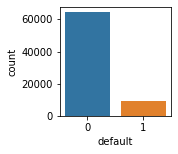

In [17]:
# 'default' (target variable)

plt.figure(figsize=(2,2))
sns.countplot(df_train.default)
plt.show()

There are significantly fewer default clients than non-default clients.

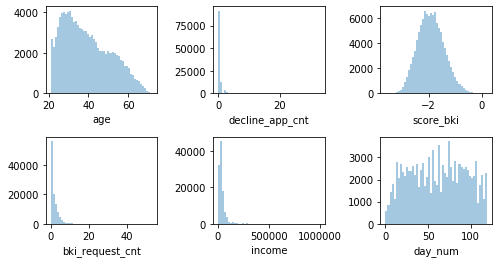

In [18]:
# numeric columns plots

fig, axes = plt.subplots(2, 3, figsize=(8,4))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
for col, i in zip(num_cols, range(6)):
    sns.distplot(df[col], kde=False, ax=axes.flat[i])

Only "score_bki" looks like a normal distribution.

In [19]:
# take a logarithm to improve the ditribution

for col in ['age', 'decline_app_cnt', 'bki_request_cnt','income','day_num']:
    df.loc[:,col] = np.log(df[col] + 1)        

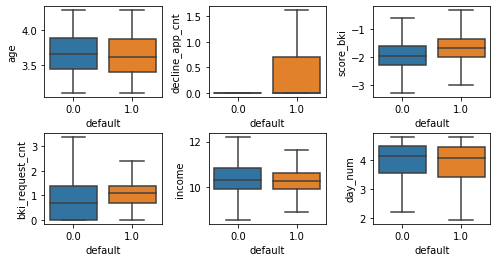

In [20]:
# boxplots for numerical variables

fig, axes = plt.subplots(2, 3, figsize=(8,4))
plt.subplots_adjust(wspace = 0.4, hspace=0.4)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x=target, y=num_cols[i], data=df, orient='v', ax=axes[i], showfliers=False)    

<pre>
on average default clients
- are younger
- have larger number of canceled applications, 
- have larger score_bki, 
- have more requests to bki, 
- have lower income
</pre>

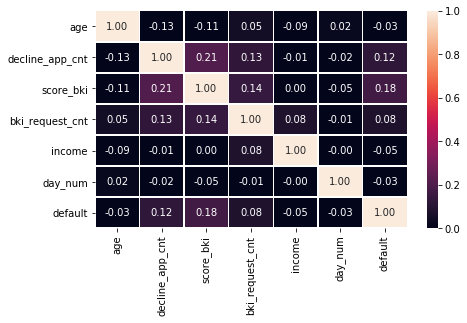

In [21]:
# Pearson correlation for numeric columns

plt.figure(figsize=(7,4))
sns.heatmap(df[num_cols + [target]].corr(), 
            vmin=0, vmax=1, annot=True, fmt='.2f', linewidths=.5 )

#sns.heatmap(df_train[num_cols + [target]].corr(), vmin=0,vmax=1,annot=True,fmt='.2f', linewidths=.5 )
plt.show()

In general, the numerical features are weakly correlated.

In [22]:
# update df_train
df_train = df[df.part==1]

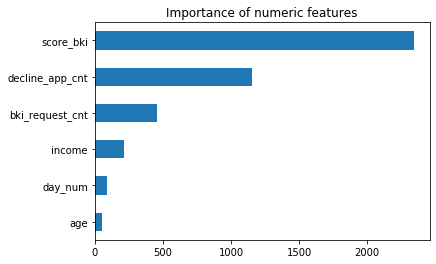

In [23]:
# importance of numeric features

imp_num = Series(f_classif(df_train[num_cols], df_train[target])[0],
                 index = num_cols).sort_values()
imp_num.plot(kind = 'barh')
plt.title('Importance of numeric features')
plt.show()

So, the most important feature among the numerical is 'score_bki', then - 'declain_app_cnt', 
The least significant attribute is 'age'.

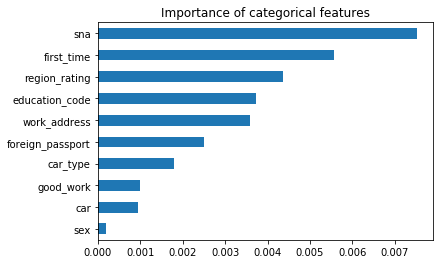

In [24]:
# importance of categorical and bin

mi = mutual_info_classif(df_train[cat_cols+bin_cols], df_train[target], discrete_features=True)
#mi = mutual_info_classif(df_train[cat_cols+bin_cols], df_train[target], discrete_features=True)
pd.Series(mi, index=cat_cols+bin_cols).sort_values(ascending=True).plot(kind='barh')
plt.title('Importance of categorical features')
plt.show()

<pre>
The most significant features: 'sna','first_time','address'
The least: sex
</pre>

# 3. Machine learning

### 3.1. Data preparation

In [25]:
df = df.drop(['education_code'], axis=1)
cat_cols[0] = 'education'
print(cat_cols)

['education', 'work_address', 'sna', 'first_time', 'region_rating']


In [26]:
# categorical columns

# OneHotLabels with get_dummies
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

### 3.2. Build a model

In [28]:
train_data = df.query('part == 1').drop(['part', 'client_id'], axis=1)
test_data = df.query('part == 0').drop(['part', 'client_id'], axis=1)
print('train: ', train_data.shape)
print('test: ', test_data.shape)

train:  (73799, 36)
test:  (36349, 36)


In [29]:
X = train_data.drop(['default'], axis=1)
y = train_data.default.values # target

In [30]:
# split the data into the training and test parts

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape) 
print(X_test.shape)

(59039, 35)
(14760, 35)


In [31]:
model = LogisticRegression(random_state=RANDOM_SEED, max_iter = 1000) # type of model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print metrics
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

Accuracy: 0.8751
Precision: 0.4045
Recall: 0.0197
F1: 0.0376


In [32]:
# instantiate a model
model = LogisticRegression(random_state=RANDOM_SEED) # type of model

# Selection of hyperparameters
iter_ = 1000 # iterations
epsilon_stop = 1e-5 # delta


param_grid = [
#    {'penalty': ['l1', 'l2'],
#   'C': [7,10],
#    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['balanced'], 'multi_class': ['auto','ovr'], 
      'max_iter':[iter_], 
     'tol':[epsilon_stop]
    }
]


In [33]:
# Create a grid search

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)

# fit the gridsearch with training data
gridsearch.fit(X_train, y_train)

model = gridsearch.best_estimator_

In [34]:
# View best hyperparameters
best_parameters = model.get_params()
f=lambda param_name: ('\t%s: %r' % (param_name, best_parameters[param_name]))
print(*map( f, best_parameters.keys() ), sep='\n')

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 1000
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'lbfgs'
	tol: 1e-05
	verbose: 0
	warm_start: False


In [35]:
# build model with best parameters

model = LogisticRegression(random_state=RANDOM_SEED, 
                        C = 7,
                        class_weight = 'balanced',
                        dual = False,
                        fit_intercept = True,
                        intercept_scaling = 1,
                        l1_ratio = None,
                        max_iter = 1000,
                        multi_class = 'auto',
                        n_jobs = None,
                        penalty = 'l2',                        
                        solver = 'liblinear',
                        tol = 1e-05,
                        verbose = 0,
                        warm_start = False
                          )

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

Accuracy: 0.6697
Precision: 0.2252
Recall: 0.6836
F1: 0.3388


#### 3.3. Build ROC AUС

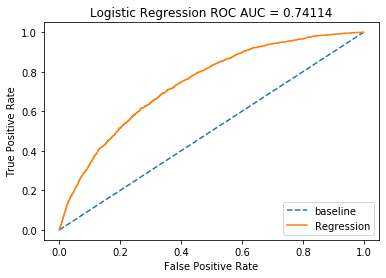

In [38]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### 3.4. Submission

In [39]:
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values # target

X_test = test_data.drop(['default'], axis=1)

In [40]:
y_pred_prob = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)